Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


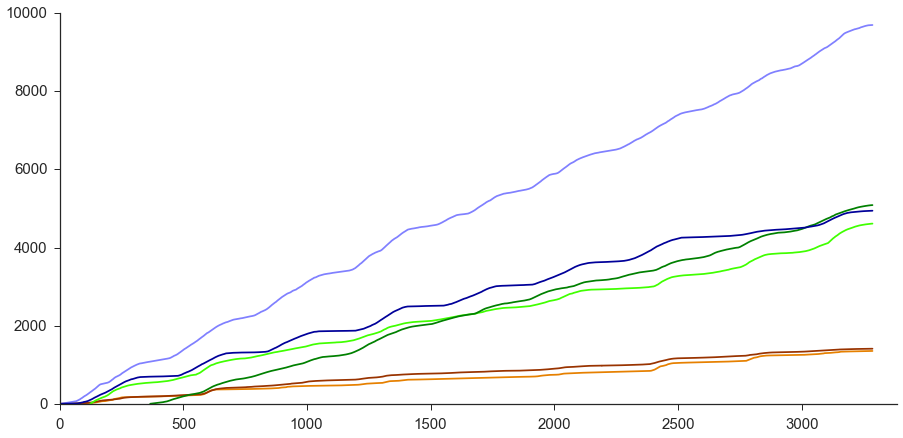

In [94]:
# ------- Notebook config
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15.0, 12.0)
import matplotlib.pyplot as plt

# ------- Load dependencies
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import pysal as ps 
import gdal

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon as PolygonM

import rasterio
import os
from rasterstats import zonal_stats


# Directory with daily files for the figure
fluxfileDir = 'C:\\Research\\NASA_USDA-NIFA_ROSES_2016\\'

# Color scheme
gcolour=[0.9,0.5, 0.0];
ngcolour=[0.9, 0.6, 0.0];
scolour=[0.6, 0.2, 0];
jcolour=[0.25, 1.0, 0.0];
pjcolour=[0.0, 0.5, 0.0];
pjgcolour=[0.2, 0.5, 0.0];
pcolour=[0.5, 0.5, 1.0];
mcolour=[0.0, 0.0, 0.6];
siteColors = [gcolour, scolour, jcolour, pjcolour, pcolour, mcolour]

# Filenames of each daily file
seg = 'US-Seg_2007_2016_daily.txt'
ses = 'US-Ses_2007_2016_daily.txt'
wjs = 'US-Wjs_2007_2016_daily.txt'

mpj = 'US-Mpj_2007_2016_daily.txt'
vcp = 'US-Vcp_2007_2016_daily.txt'
vcm = 'US-Vcm_2007_2016_daily.txt'

# Read in and concat each file with an extra column, SITE
Seg = pd.read_csv(fluxfileDir + seg, sep = '\t')
Ses = pd.read_csv(fluxfileDir + ses, sep = '\t')
Wjs = pd.read_csv(fluxfileDir + wjs, sep = '\t')

Mpj = pd.read_csv(fluxfileDir + mpj, sep = '\t')
Vcp = pd.read_csv(fluxfileDir + vcp, sep = '\t')
Vcm = pd.read_csv(fluxfileDir + vcm, sep = '\t')

Seg['SITE'] = 'Seg'
Ses['SITE'] = 'Ses'
Wjs['SITE'] = 'Wjs'

Mpj['SITE'] = 'Mpj'
Vcp['SITE'] = 'Vcp'
Vcm['SITE'] = 'Vcm'

# Concatenate files into single pandas df
# then replace -9999 with NaN
fluxdf = pd.concat([Seg, Ses, Wjs, Mpj, Vcp, Vcm])
fluxdf[fluxdf == -9999] = np.nan

# Setup a color palette for the sites
forestTS = ['#d8b365','#91bfdb','#5ab4ac','#d8b365','#91bfdb','#5ab4ac']

# Quick cumulative comparison
f, (ax) = plt.subplots(1,1, figsize = (15, 7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    siteflux = fluxdf[fluxdf.SITE == site]
    siteflux.GPP.cumsum().plot(ax = ax, color = siteColors[idx])
    idx = idx + 1

sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)
sns.despine()

Mpj 18    2010
Name: year, dtype: int64 796.47010093 36    2013
Name: year, dtype: int64 547.472067963
Seg 37    2013
Name: year, dtype: int64 250.791024926 25    2011
Name: year, dtype: int64 61.632941572
Ses 8    2008
Name: year, dtype: int64 231.64280494 26    2011
Name: year, dtype: int64 78.293081027
Vcm 3    2007
Name: year, dtype: int64 694.41954209 45    2014
Name: year, dtype: int64 202.126472892
Vcp 22    2010
Name: year, dtype: int64 1183.25200203 28    2011
Name: year, dtype: int64 883.42774116
Wjs 53    2015
Name: year, dtype: int64 759.068819671 29    2011
Name: year, dtype: int64 354.211255887


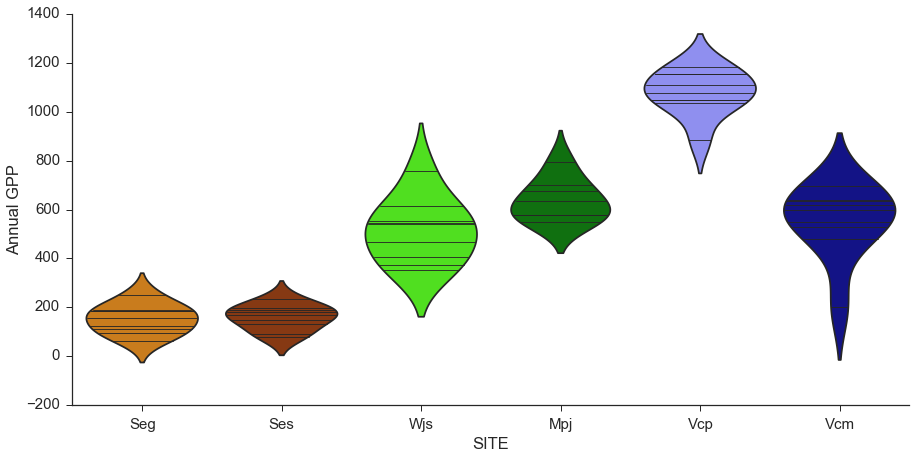

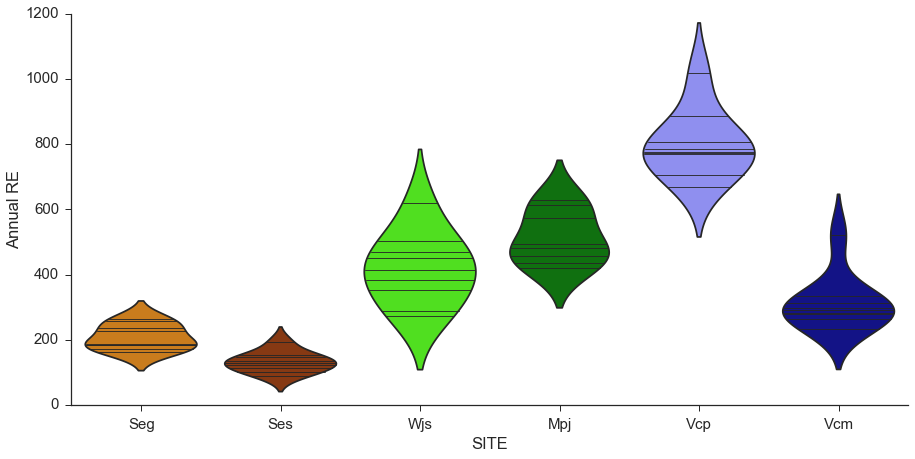

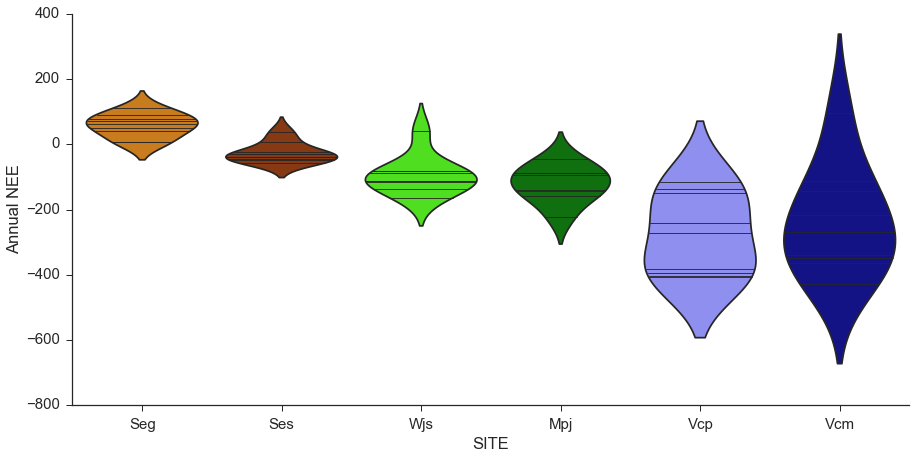

In [95]:
annualSums = fluxdf.groupby(['year', 'SITE']).sum().reset_index()
annualMeans = fluxdf.groupby(['year', 'SITE']).mean().reset_index()

for site in np.unique(annualSums.SITE):
    maxgpp = annualSums[annualSums.SITE == site].GPP.max()
    mingpp = annualSums[annualSums.SITE == site].GPP.min()
    yearofMax = annualSums[annualSums.GPP == maxgpp].year
    yearofMin = annualSums[annualSums.GPP == mingpp].year
    print site, yearofMax, maxgpp, yearofMin, mingpp
    
f, (ax1) = plt.subplots(1, figsize = (15, 7))

fluxViolin = sns.violinplot(x="SITE", y="GPP",
                     data=annualSums, palette=sns.color_palette(siteColors),
                     order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
                     scale = 'count',bw = 0.75,
                     inner="stick",
                     ax = ax1)
ax1.set_ylabel('Annual GPP')
sns.despine()

plt.savefig('AnnualGPPDistro.tif')

annualSums = fluxdf.groupby(['year', 'SITE']).sum().reset_index()
annualMeans = fluxdf.groupby(['year', 'SITE']).mean().reset_index()

    
f, (ax1) = plt.subplots(1, figsize = (15, 7))

fluxViolin = sns.violinplot(x="SITE", y="RECO",
                     data=annualSums, palette=sns.color_palette(siteColors),
                     order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
                     scale = 'count',bw = 0.75,
                     inner="stick",
                     ax = ax1)
ax1.set_ylabel('Annual RE')
sns.despine()

plt.savefig('AnnualREDistro.tif')

annualSums = fluxdf.groupby(['year', 'SITE']).sum().reset_index()
annualMeans = fluxdf.groupby(['year', 'SITE']).mean().reset_index()
    
f, (ax1) = plt.subplots(1, figsize = (15, 7))

fluxViolin = sns.violinplot(x="SITE", y="FC_F",
                     data=annualSums, palette=sns.color_palette(siteColors),
                     order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
                     scale = 'count',bw = 0.75,
                     inner="stick",
                     ax = ax1)
ax1.set_ylabel('Annual NEE')
sns.despine()

plt.savefig('AnnualNEEDistro.tif')

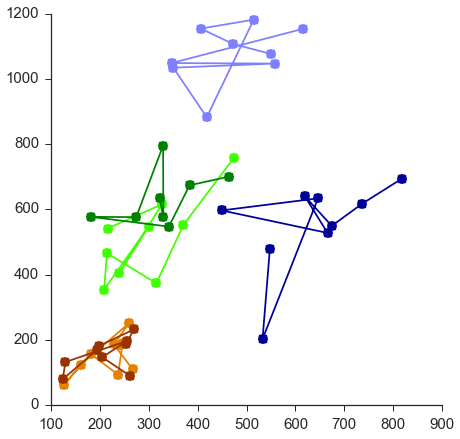

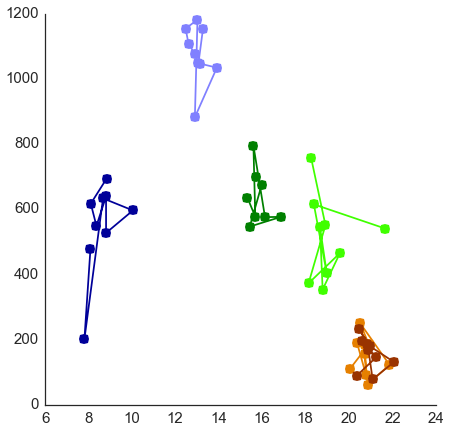

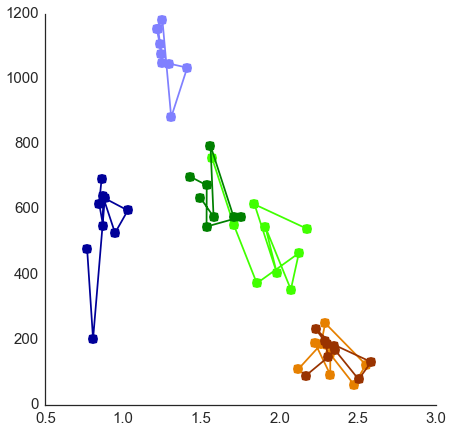

In [96]:
f, (ax1) = plt.subplots(1, figsize = (7,7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    siteflux = annualSums[annualSums.SITE == site]
    ax1.plot(siteflux['P_F'], siteflux['GPP'],marker = 'o', markersize = 10, 
                color = siteColors[idx], markerfacecolor = siteColors[idx], 
                markeredgecolor = 'black')
    idx = idx + 1
ax.set_xlabel('Cumulative Precip')
ax.set_ylabel('Anual GPP')
sns.set_style('white')
sns.despine()
plt.savefig('GPPxPRECIP.tif')

f, (ax1) = plt.subplots(1, figsize = (7,7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    sitefluxM = annualMeans[annualMeans.SITE == site]
    siteflux = annualSums[annualSums.SITE == site]

    ax1.plot(sitefluxM['TA_F_max'], siteflux['GPP'],marker = 'o', markersize = 10, 
                color = siteColors[idx], markerfacecolor = siteColors[idx], 
                markeredgecolor = 'black')
    idx = idx + 1
ax.set_xlabel('Cumulative Precip')
ax.set_ylabel('Anual GPP')
sns.set_style('white')
sns.despine()
plt.savefig('GPPxTA_MAX.tif')

f, (ax1) = plt.subplots(1, figsize = (7,7))
idx = 0
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    sitefluxM = annualMeans[annualMeans.SITE == site]
    siteflux = annualSums[annualSums.SITE == site]

    ax1.plot(sitefluxM['VPD_F_max'], siteflux['GPP'],marker = 'o', markersize = 10, 
                color = siteColors[idx], markerfacecolor = siteColors[idx], 
                markeredgecolor = 'black')
    idx = idx + 1
ax.set_xlabel('Cumulative Precip')
ax.set_ylabel('Anual GPP')
sns.set_style('white')
sns.despine()
plt.savefig('GPPxVPDMAX.tif')


In [130]:
segH = Seg[Seg.year == 2013]
segL = Seg[Seg.year == 2011]
segH['status'] = 'Wet year'
segL['status'] = 'Dry year'

sesH = Ses[Ses.year == 2008]
sesL = Ses[Ses.year == 2011]
sesH['status'] = 'Wet year'
sesL['status'] = 'Dry year'

wjsH = Wjs[Wjs.year == 2015]
wjsL = Wjs[Wjs.year == 2011]
wjsH['status'] = 'Wet year'
wjsL['status'] = 'Dry year'


mpjH = Mpj[Mpj.year == 2010]
mpjL = Mpj[Mpj.year == 2013]
mpjH['status'] = 'Wet year'
mpjL['status'] = 'Dry year'

vcpH = Vcp[Vcp.year == 2010]
vcpL = Vcp[Vcp.year == 2011]
vcpH['status'] = 'Wet year'
vcpL['status'] = 'Dry year'

vcmH = Vcm[Vcm.year == 2010]
vcmL = Vcm[Vcm.year == 2011]
vcmH['status'] = 'Wet year'
vcmL['status'] = 'Dry year'

highLow = pd.concat([vcmH,vcmL,vcpH,vcpL,mpjH,mpjL,wjsH,wjsL,sesH,sesL,segH,segL])
highLowSum = highLow.groupby(['SITE','status','year']).sum().reset_index()




#######

segH = Seg[Seg.year == 2010]
segL = Seg[Seg.year == 2011]
segH['status'] = 'Wet year'
segL['status'] = 'Dry year'

sesH = Ses[Ses.year == 2010]
sesL = Ses[Ses.year == 2011]
sesH['status'] = 'Wet year'
sesL['status'] = 'Dry year'

wjsH = Wjs[Wjs.year == 2010]
wjsL = Wjs[Wjs.year == 2011]
wjsH['status'] = 'Wet year'
wjsL['status'] = 'Dry year'


mpjH = Mpj[Mpj.year == 2010]
mpjL = Mpj[Mpj.year == 2011]
mpjH['status'] = 'Wet year'
mpjL['status'] = 'Dry year'

vcpH = Vcp[Vcp.year == 2010]
vcpL = Vcp[Vcp.year == 2011]
vcpH['status'] = 'Wet year'
vcpL['status'] = 'Dry year'

vcmH = Vcm[Vcm.year == 2010]
vcmL = Vcm[Vcm.year == 2011]
vcmH['status'] = 'Wet year'
vcmL['status'] = 'Dry year'

highLow = pd.concat([vcmH,vcmL,vcpH,vcpL,mpjH,mpjL,wjsH,wjsL,sesH,sesL,segH,segL])
highLowSum = highLow.groupby(['SITE','status','year']).sum().reset_index()

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

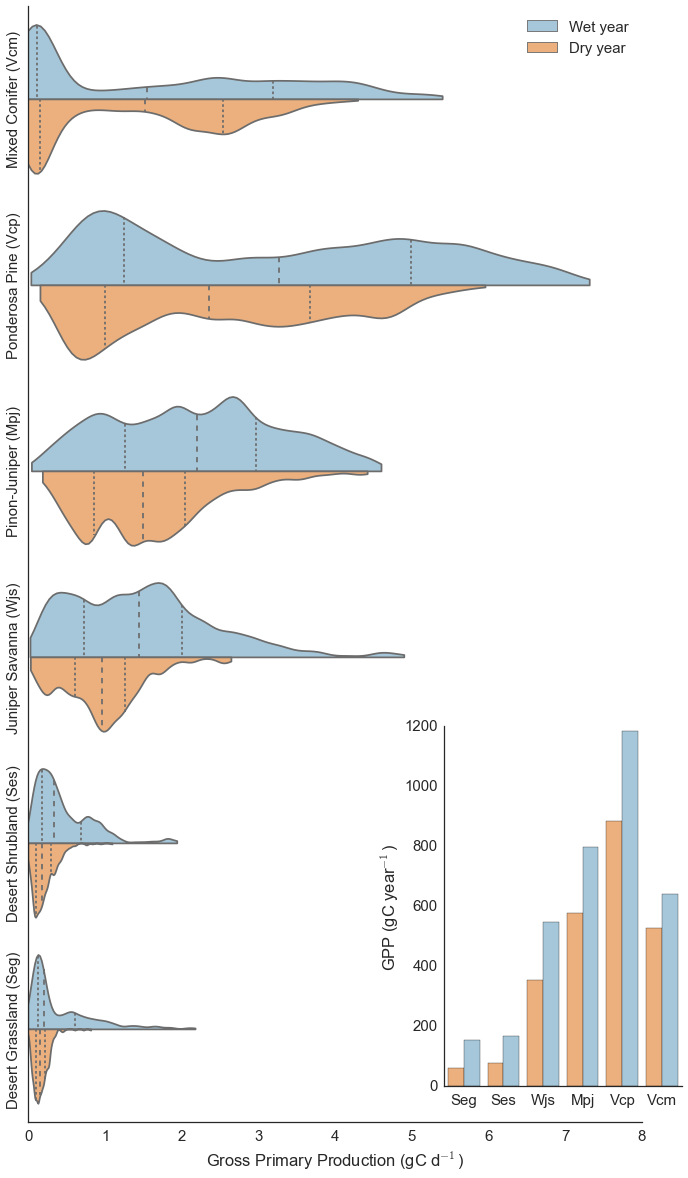

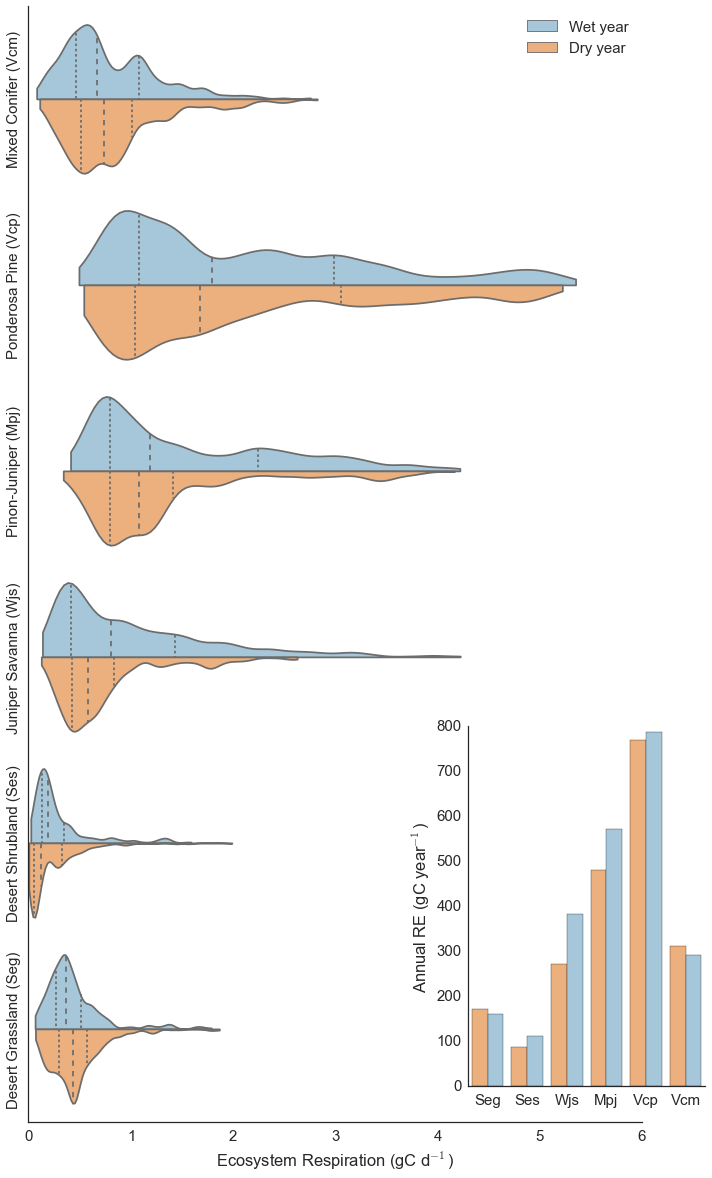

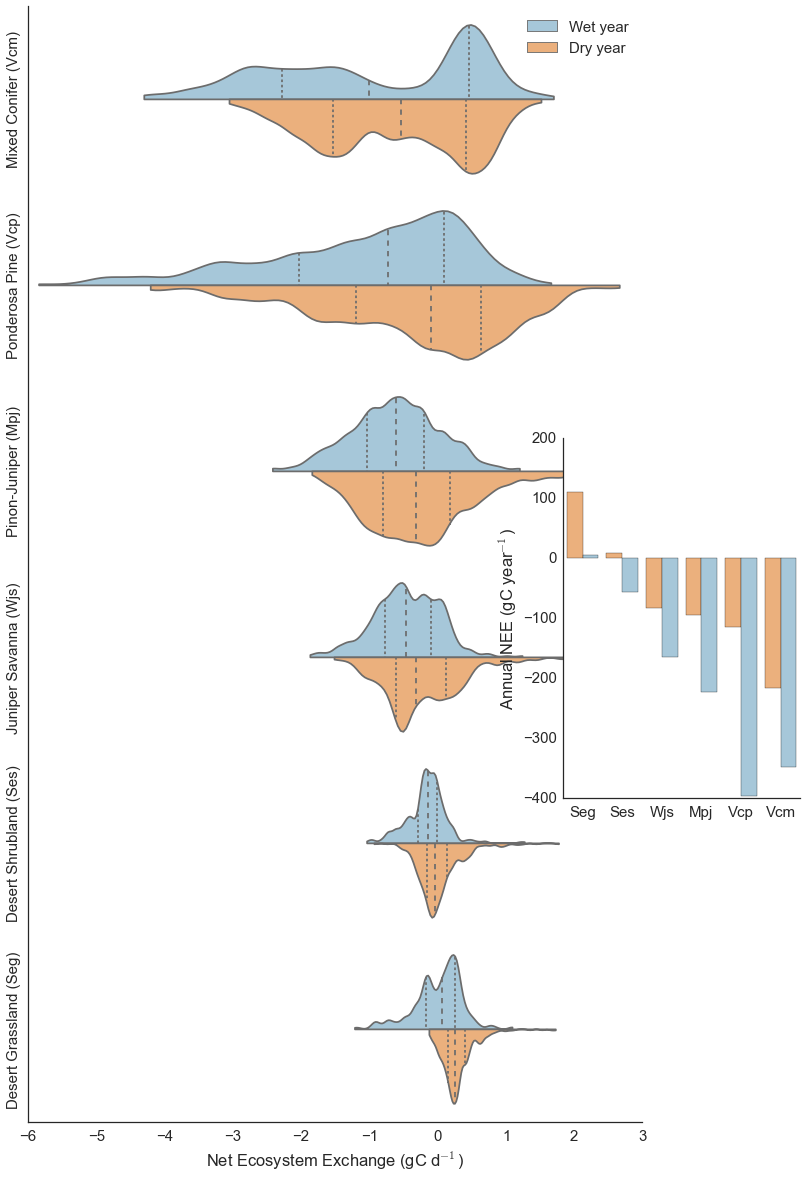

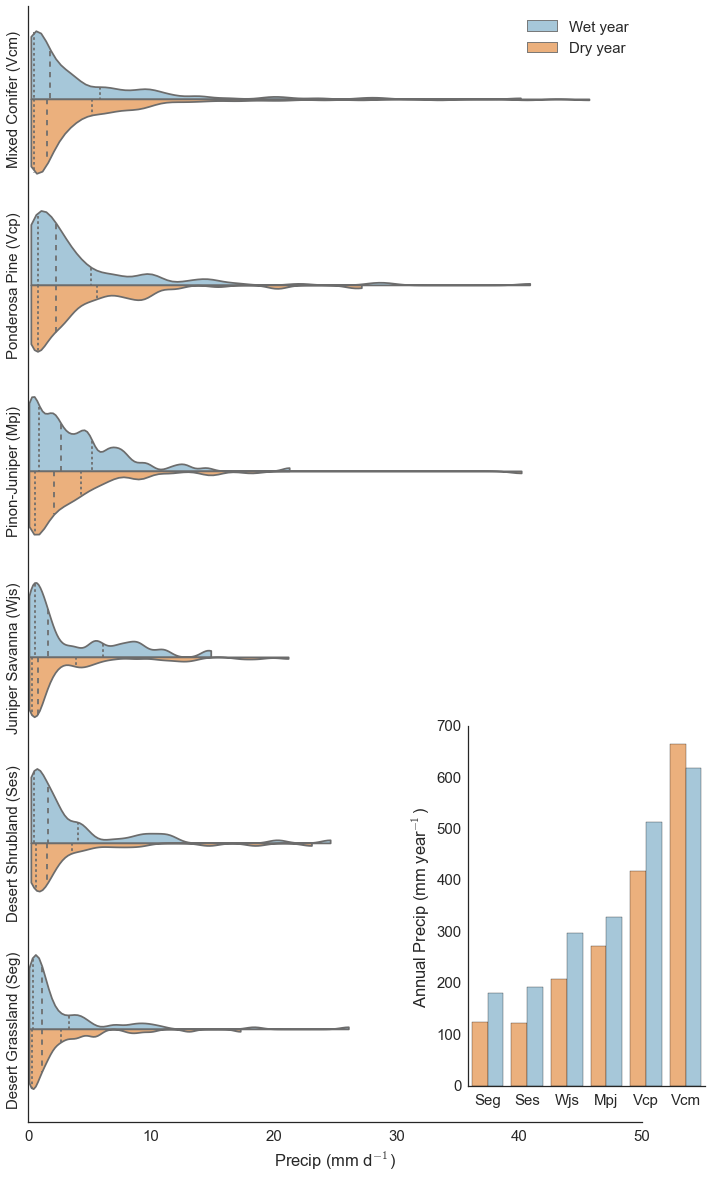

In [98]:
f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="GPP", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.65, 0.15, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="GPP", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('GPP (gC year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Gross Primary Production (gC d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtGPP.tif')



f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="RECO", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.68, 0.15, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="RECO", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('Annual RE (gC year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Ecosystem Respiration (gC d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtRE.tif')



f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="FC_F", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.80, 0.35, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="FC_F", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('Annual NEE (gC year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Net Ecosystem Exchange (gC d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtNEE.tif')




# Set days with no rain to NaN
highLow[highLow.P_F <= 0] = np.nan


f, (ax) = plt.subplots(1, figsize = (11, 20))

fluxViolin = sns.violinplot(x="P_F", y="SITE", hue = 'status',
                     data=highLow, palette=sns.color_palette(["#9ecae1","#fdae6b"]),
                     scale = 'count', split = 'true',
                     inner="quartile",cut = 0,bw = 0.15,
                     ax = ax)

left, bottom, width, height = [0.68, 0.15, 0.30, 0.25]
axsub = f.add_axes([left, bottom, width, height])
sns.barplot(x="SITE", y="P_F", hue="status", data=highLowSum, 
            order = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm'], 
            palette=sns.color_palette(["#fdae6b","#9ecae1"]),ax = axsub)

axsub.legend('')
axsub.set_ylabel('Annual Precip (mm year$^{-1}$)')
axsub.set_xlabel('')

ax.set_ylabel(' ')
ax.set_xlabel('Precip (mm d$^{-1}$)')
ax.legend()
ax.set_yticklabels(['Mixed Conifer (Vcm)','Ponderosa Pine (Vcp)','Pinon-Juniper (Mpj)',
                   'Juniper Savanna (Wjs)', 'Desert Shrubland (Ses)', 'Desert Grassland (Seg)'], rotation = 90)

sns.despine()
plt.savefig('TowerDroughtPRECIP.tif')

Seg
Ses
Wjs
Mpj
Vcp
Vcm


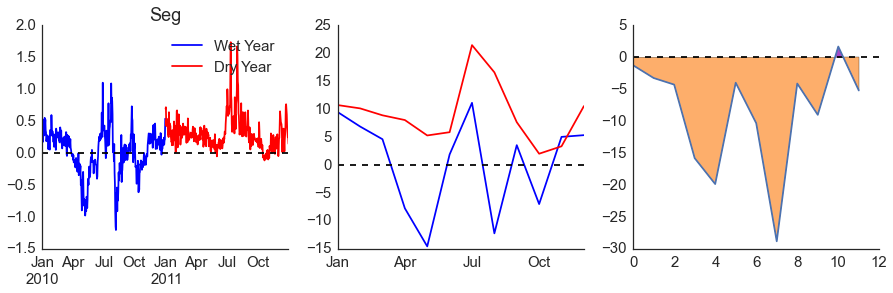

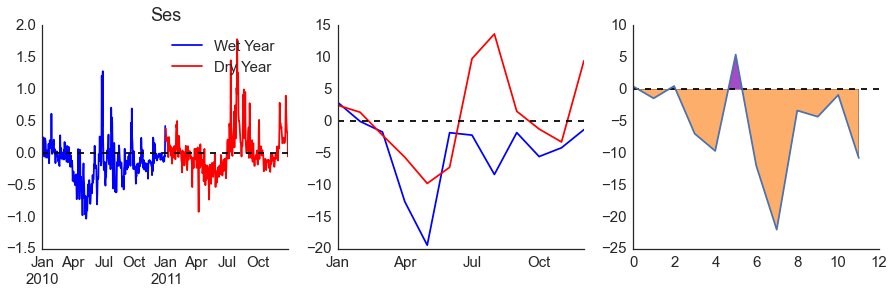

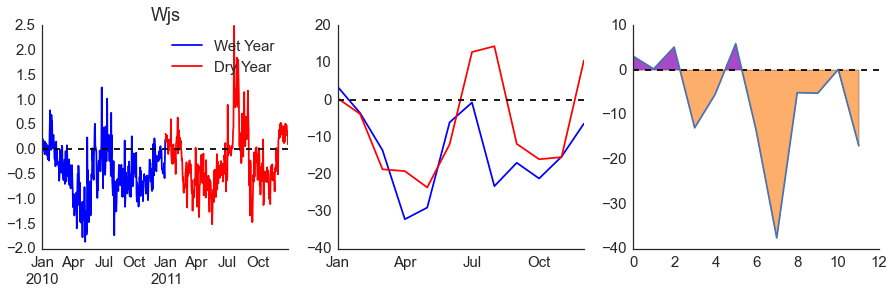

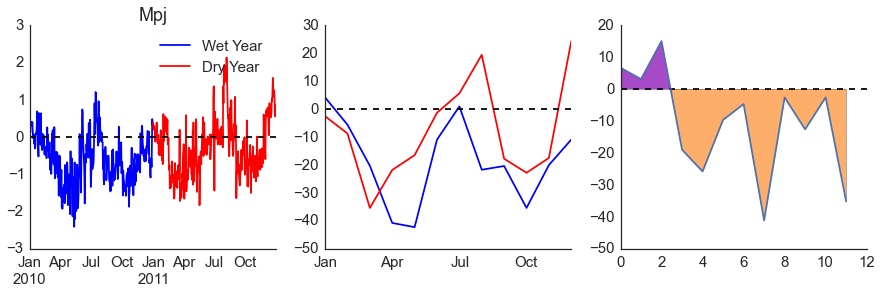

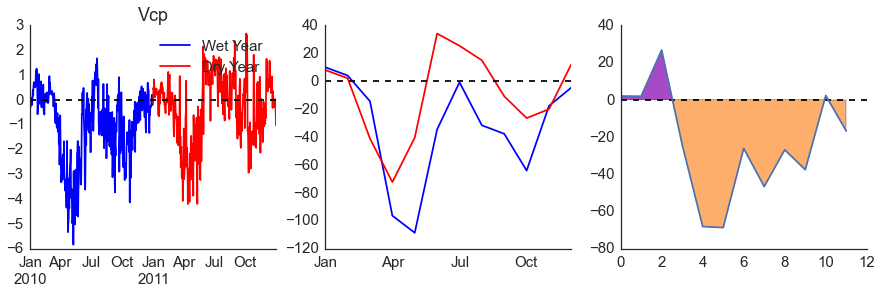

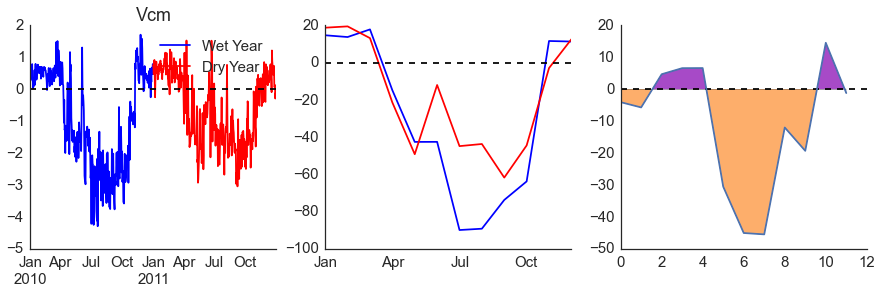

In [178]:
for site in ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']:
    thisSite = highLow[highLow.SITE == site]
    wetYear = thisSite[thisSite.status == 'Wet year']
    dryYear = thisSite[thisSite.status == 'Dry year']
    print site

    wetYear.index = pd.date_range('2010-1-1','2010-12-31')
    dryYear.index = pd.date_range('2011-1-1','2011-12-31')
    
    wetMonths = wetYear.groupby(wetYear.index.month).sum()
    dryMonths = dryYear.groupby(dryYear.index.month).sum()
    wetMonths['Zero'] = 0
    
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 4))

    wetYear.FC_F.plot(ax = ax1, c = 'blue')
    dryYear.FC_F.plot(ax = ax1, c = 'red')
    wetMonths.FC_F.plot(ax = ax2, c = 'blue')
    dryMonths.FC_F.plot(ax = ax2, c = 'red')
    ax1.axhline(y=0, color = 'k', linestyle = '--')
    ax2.axhline(y=0, color = 'k', linestyle = '--')
    ax3.axhline(y=0, color = 'k', linestyle = '--')
    y2 = (wetMonths.FC_F - dryMonths.FC_F)
    y1 = wetMonths.Zero
    ax3.fill_between(np.arange(0,12,1), y1, y2, 
                     where= y2 <= y1, facecolor='#fdae6b', interpolate=True)
    ax3.fill_between(np.arange(0,12,1), y1, y2, 
                     where= y2 >= y1, facecolor='#a74ac7', interpolate=True)

    ax3.plot(wetMonths.FC_F - dryMonths.FC_F)

    ax2.set_xticks([1,4,7,10])
    ax2.set_xticklabels(['Jan','Apr','Jul','Oct'])
    ax1.set_title(site)
    ax1.legend(['Wet Year','Dry Year'])
    sns.despine()
    plt.savefig('draftDroughts_' + site + '.tif')
    
